# Fanal, a neutrino-less beta decay experiment 

## An open exercise

##  Simultaneous fit to control and signal samples

### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata

February 2021 - February 2022


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD THE FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.pltfanal as pltfn    # analysis plotting function specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objective:

  * **Do a simultaneous fit to signal and control smaples to better estimate the number of signal events**.

### Tasks

   * Open the data file (HDF) and access the simulated data (MC) of 214Bi, 208Tl and bb0nu. 

   * Establish two selections: signal and control.
   
   * Do a simultaneous fit two the energy on both samples. 
   
   * Estimate the uncertainties on the number of signal events.

   * Estimate the half-life for different number signal scenarios.

## Notes

  * A combined likelihood fit consider two samples (${\bf x}_1, {\bf x}_2$) that share the same parameters ${\bf n}$. 
  
  * Each sample has a given combined pdf $f_1({\bf x}_1 | {\bf n}), \; f_2({\bf x}_2 | {\bf n})$
  
  * The combined loglike is the sum of both log likelihoods
  
  $$
  \mathrm{log} \mathcal{L}({\bf x}_1 | {\bf n}) +   \mathrm{log} \mathcal{L}({\bf x}_2 | {\bf n})
  $$
  
  * In this case the control sample, is a sample with a large content of bkg. It helps to define the number of background events in the signal sample. 


## Main parameters

In [5]:
coll          = collpars.collaboration
ntracks_range = collpars.ntracks_range
eblob2_range  = collpars.eblob2_range
erange        = collpars.erange
eroi          = collpars.eroi

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : ({:d}, {:6.2f})'.format(*ntracks_range))
print('Blob-2 energy range       : ({:6.3f}, {:6.3f}) MeV'.format(*eblob2_range))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Collaboration             : new_beta
number of tracks range    : (1,   1.10)
Blob-2 energy range       : ( 0.400,  1.200) MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


In [6]:
# list of the analisys selection variables names and ranges
varnames  = ['num_tracks', 'blob2_E', 'E']
varranges = [ntracks_range, eblob2_range, erange]
print('analysis varnames   : ', varnames)
print('analysis varranges  : ', varranges)

# list of the reference selction variable names and rages to get pdfs for the MC
refnames  = ['num_tracks', 'E']
refranges = [ntracks_range, erange]
print('reference varnames  : ', refnames)
print('reference varranges : ', refranges)

# list of the control selection variable names and rages to get pdfs for the MC
connames  = ['num_tracks', 'E']
conranges = [(2, 20), erange]
print('control varnames    : ', connames)
print('control varranges   : ', conranges)


analysis varnames   :  ['num_tracks', 'blob2_E', 'E']
analysis varranges  :  [(1, 1.1), (0.4, 1.2), (2.4, 2.7)]
reference varnames  :  ['num_tracks', 'E']
reference varranges :  [(1, 1.1), (2.4, 2.7)]
control varnames    :  ['num_tracks', 'E']
control varranges   :  [(2, 20), (2.4, 2.7)]


In [7]:
# number of  blind events
nevts_Bi = collpars.nevts_Bi
nevts_Tl = collpars.nevts_Tl
print('Number of bkg events in full data : Bi = {:6.2f}, Tl = {:6.2f}.'.format(nevts_Bi, nevts_Tl))

Number of bkg events in full data : Bi = 1403.27, Tl = 20673.20.


## Access the data

In [8]:
dirpath = '/Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

mcs      = [mcbb, mcbi, mctl]
tsamples = ['bb', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$',r'$^{214}$Bi', r'$^{208}$Tl']

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_new_beta.h5


## Check method with a mc experiment

  * Generate a MC experiments with number of events compatible with estimated number of bkg events and a hipothetical number of signal events.
  
  * Fit the energy distribution of the signal and control sample to its components pdfs: bb, Bi. Tl
  
  * Do a profile scan to estimate the confidence interval and p0-value for this example

### Exercise:

  * Generate other experiments with different number of signal events to study the performance of the fit

In [9]:
def nevts_total(factor = 1.):
    """ Compute the number of total events
        Assumes that the number of signal in RoI is a factor of  number of Bi en RoI.
    """
    nevts_Bi_RoI    = collpars.nevts_Bi_RoI
    eff_bb_RoI      = collpars.eff_bb_RoI
    nevts           = (factor * nevts_Bi_RoI / eff_bb_RoI, nevts_Bi, nevts_Tl)
    return np.array(nevts)

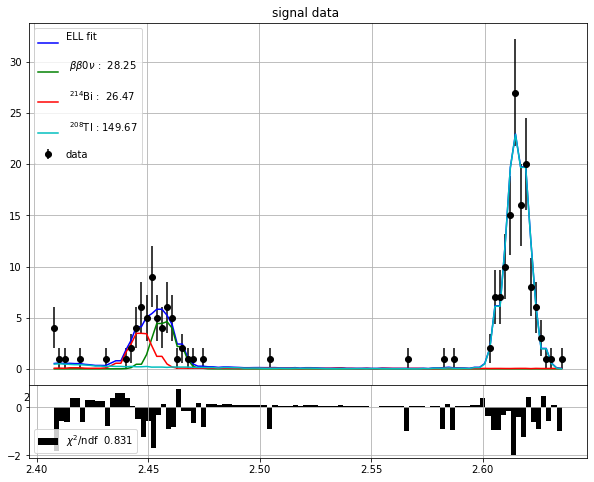

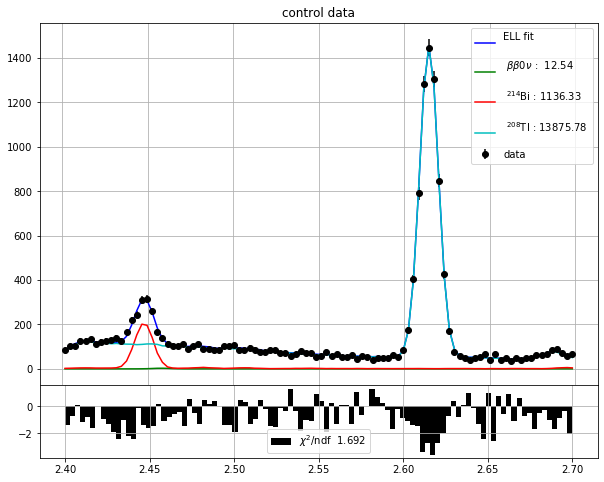

In [10]:
# set the number of total events
factor  = 1.
nevts   = nevts_total(factor)

# define the simultaneous ELL fit
fit     = fn.prepare_fit_simell(mcs, nevts, varnames, varranges,
                              refnames, refranges, connames, conranges)

# generate an experiment using the mc samples and a given number of events of each sample
mcdata  = fn.generate_mc_experiment(mcs, nevts)

result, values, ell, nevts_exp  = fit(mcdata)
nevts_est = result.x if result.success else nevts_exp

pltfn.plot_fit_simell(values, nevts_est, ell)

## Parameter uncertanties estimation

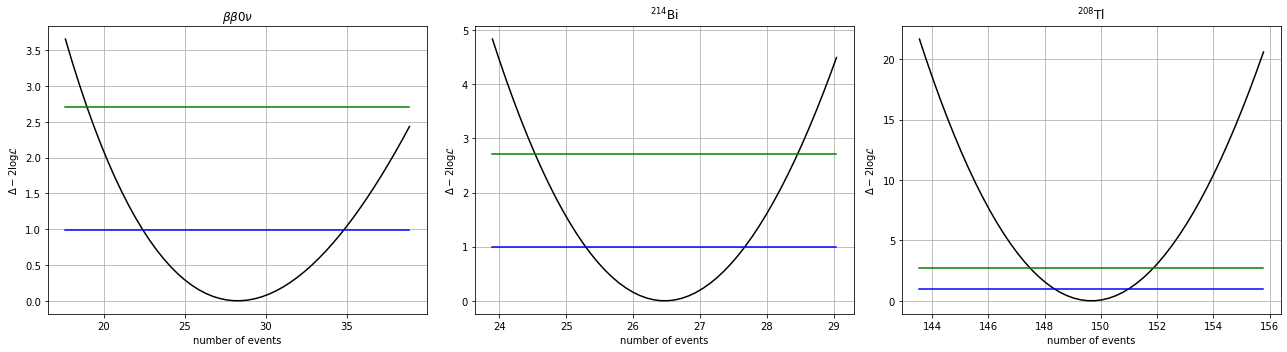

In [11]:
nis, tmus = fn.tmu_scan(values, result.x, ell, sizes = (2., 0.5, 0.5))
pltfn.plot_tmu_scan(nis, tmus)

Notice how the bkg and the signal uncertainties are reduced compared with the fit only on the signal region.

In [12]:
cl    = 0.68
mucis = [efit.tmu_conf_int(ni, tmu, cl) for ni, tmu in zip(nis, tmus)]
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = ({:5.2f}, {:5.2f})'.format(tsamples[i], 100*cl, *ci))

Number of bb events CI at   68 % CL = (22.83, 34.54)
Number of Bi events CI at   68 % CL = (25.37, 27.57)
Number of Tl events CI at   68 % CL = (148.54, 150.79)


In [13]:
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = {:5.2f}  {:5.2f} +{:5.2f}'.format(tsamples[i], 100*cl, 
                                                                                        result.x[i],
                                                                                        *(ci - result.x[i])))

Number of bb events CI at   68 % CL = 28.25  -5.42 + 6.29
Number of Bi events CI at   68 % CL = 26.47  -1.10 + 1.10
Number of Tl events CI at   68 % CL = 149.67  -1.12 + 1.12


## Null hypothesis p-value calculation

In [14]:
q0 = efit.tmu(values, ell, result.x, 0.)
z0 = np.sqrt(q0)
p0 = 1 - stats.norm.cdf(z0)
#p0 = stats.chi2.sf(q0, 1)/2.
print('H0 p value {:1.2e}, {:4.2f} sigmas'.format(p0, z0))

H0 p value 2.38e-14, 7.54 sigmas


## Apendix: Step by step

Total number of events     : bb =  41.91,  Bi = 1403.27,  Tl = 20673.20, 
Expected number of events  : bb =  21.75,  Bi =  25.25,  Tl = 150.85, 
Fit success ?              : True
Estimated number of events : bb =  21.83,  Bi =  26.53,  Tl = 151.76, 


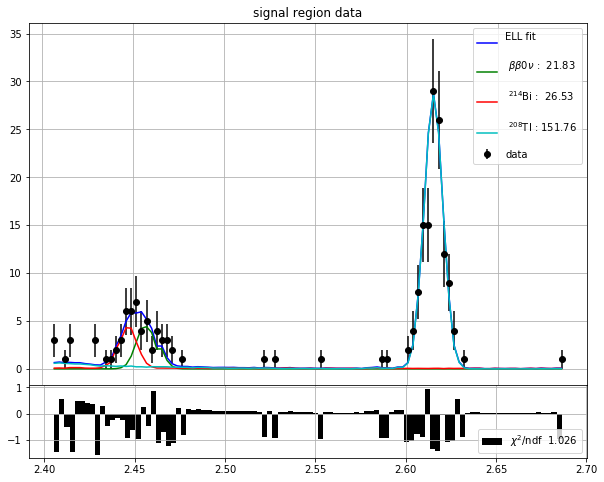

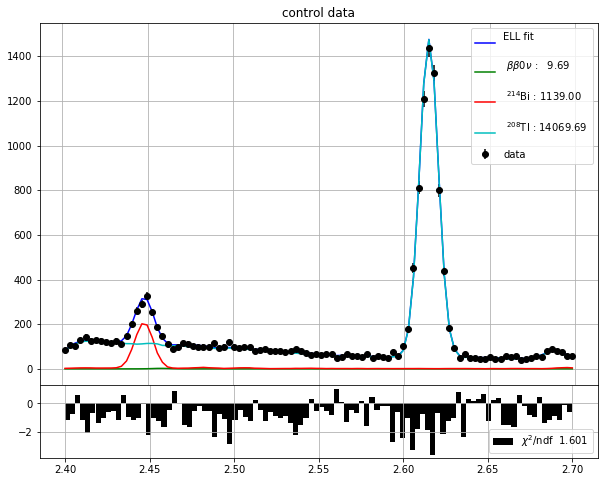

In [15]:
# set the number of events
factor          = 1.
nevts           = nevts_total(factor)

# expected number of events for each mc sample
effs_signal     = np.array([ut.selection_efficiency(mc, varnames, varranges)[0] for mc in mcs])
effs_control    = np.array([ut.selection_efficiency(mc, connames, conranges)[0] for mc in mcs])
nevts_signal    = effs_signal * nevts
factor_control  = effs_control/effs_signal

# generate the ELL instace to fit the energy distribution to the energy distribution of the three mc samples
ell_signal      = fn.get_ell(mcs, refnames, refranges)
ell_control     = fn.get_ell(mcs, connames, conranges)
ell             = efit.SimulExtComPDF(ell_signal, ell_control, factor_control)

# generate an experiment using the mc samples and a given number of events of each sample
mcdata          = fn.generate_mc_experiment(mcs, nevts)

# select the data
mcdata_signal   = ut.selection_sample(mcdata, varnames, varranges)
mcdata_control  = ut.selection_sample(mcdata, connames, conranges)

# fit the energy values of the data 
varname         = 'E'
values          = (mcdata_signal[varname].values, mcdata_control[varname].values)
result          = ell.best_estimate(values, *nevts_exp)
nevts_est       = result.x

# plot the results
pltfn.plot_fit_ell(values[0], nevts_est, ell.ell_signal, title = 'signal region data')
pltfn.plot_fit_ell(values[1], nevts_est * factor_control, ell.ell_control, title = 'control data')

# print out
print('Total number of events     :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(tsamples, nevts)])
print('Expected number of events  :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(tsamples, nevts_exp)])

print('Fit success ?              :', result.success)
print('Estimated number of events :', *['{:s} = {:6.2f}, '.format(si, ni) \
                                              for si, ni in zip(tsamples, nevts_est)])